# Pretrained 3D ResNet as feature extractor (30 animal classes)

In [1]:
#%%python3 -m pip install --upgrade pip

In [2]:
!pip install mediapipe=='0.10.9'
!pip install opencv-python=='4.8.0.76'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 2.2 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from utils import VideoDataset, validate_model, train_model, display_frames, display_learning_dynamic, classification_model_metrics

In [6]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import json

In [7]:
def save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic):
    with open(f'{save_path}/{model_name}_loss_acc_dynamic.json', 'w') as f:
        json.dump(
            {
                'train_loss_dynamic': train_loss_dynamic,
                'val_accuracy_dynamic': val_accuracy_dynamic
            },
            f)

In [8]:
use_cuda = True
seed = 1

train_batch_size = 1
test_batch_size = 1
val_batch_size = 1
IMG_SIZE = 112

limit_list = [] #["динозавр", "пингвин", "кролик"]

min_frame_count = 25

lr = 0.00001
momentum = 0.0001
epoches = 15
save = True

annotations_file = "/content/drive/MyDrive/slovo/SLOVO_DF_SHORT.tsv" #"/home/jupyter/mnt/s3/rsl-videos/slovo/slovo_annotations/SLOVO_DATAFRAME.tsv"
dataloader_dir = "/content/drive/MyDrive/slovo/dataloaders/"

save_path = '/content/drive/MyDrive/slovo/models' #'/content/model'
model_name = 'ResNet_r3d_18_transferFE_Kinetics400_lr10-5'

In [9]:
video_labels = pd.read_csv(annotations_file, sep='\t')
video_labels['group_rank'] = video_labels.groupby(['text']).cumcount()+1;
video_labels['dataset'] = np.where(video_labels['group_rank']<17,'train', np.where(video_labels['group_rank']<19,'val', 'test'))
if len(limit_list)>0:
  video_labels = video_labels[video_labels.text.isin(limit_list)]
video_labels.tail(5)

,Unnamed: 0,attachment_id,text,begin,end,group_rank,dataset
595,55,25b5fb58-46dd-4fd6-9928-734460795b22,мышь,22,83,20,test
596,56,336e0e7a-ff68-427c-9a77-52626b81edd1,паук,42,74,19,test
597,57,d0ec4c00-6ff5-4089-ac9d-5a33a76fb037,паук,3,70,20,test
598,58,59ae408b-f87a-422a-bc57-2ff5af28ee57,бабочка,2,74,19,test
599,59,e421d77c-1dcd-4124-b2a4-b2415569a4dd,бабочка,63,131,20,test


In [10]:
classes = tuple(video_labels.text.unique())
n_class = len(classes)
print(f"Total number of classes: {n_class}. Example classes: {classes[:5]}")

Total number of classes: 30. Example classes: ('пингвин', 'жираф', 'лягушка', 'бегемот', 'козел')


In [11]:
classes.index('пингвин')

0

In [12]:
train_dataloader = torch.load(dataloader_dir + 'color_frames_train_dataloader.pth')
print(f"Train dataloader contains: {len(train_dataloader)} videos")
val_dataloader = torch.load(dataloader_dir + 'color_frames_val_dataloader.pth')
print(f"Val dataloader contains: {len(val_dataloader)} videos")
# test_dataloader = torch.load(dataloader_dir + 'color_frames_test_dataloader.pth')
# print(f"Test dataloader contains: {len(test_dataloader)} videos")

Train dataloader contains: 480 videos
Val dataloader contains: 60 videos


In [14]:
use_cuda = use_cuda and torch.cuda.is_available()

if use_cuda:
  for dl in [train_dataloader, val_dataloader]:
    dl.num_workers = 0
    dl.pin_memory = True
  torch.cuda.manual_seed(seed)  # Set the random seed for the current GPU
else:
  torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

print(f"Device: {device}")

Device: cuda


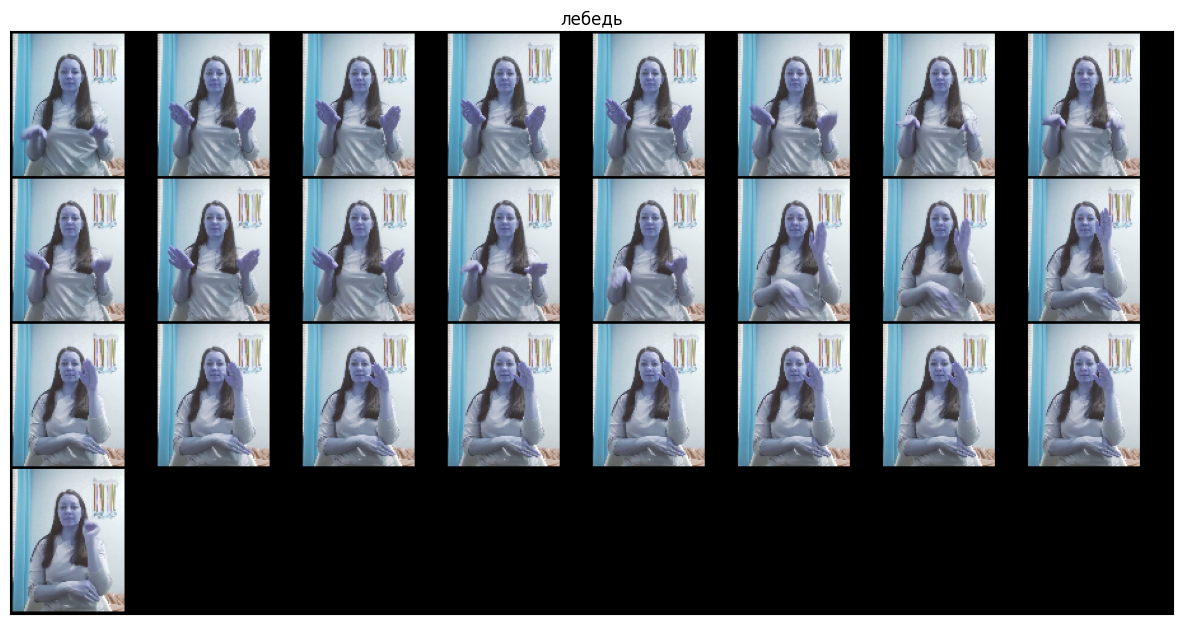

In [15]:
display_frames(n_frames=1, dataloader=train_dataloader, classes=classes)

In [17]:
frames, labels = next(iter(val_dataloader))
print(f"Frames shape: {frames.shape}") # (batch_size, -channels, frames, w, h) torch.Size([1, 3, 25, 112, 112])
print(f"Labels shape: {labels.shape}") # batch_size
print(f"Labels: {labels}") # class index

Frames shape: torch.Size([1, 3, 25, 112, 112])
Labels shape: torch.Size([1])
Labels: tensor([0])


In [18]:
resnet = torchvision.models.video.r3d_18(weights='KINETICS400_V1')
for param in resnet.parameters():
    param.requires_grad = False
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class) # reset out features fir the last layer to the number of classes
resnet.fc

Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:01<00:00, 90.0MB/s]


Linear(in_features=512, out_features=30, bias=True)

In [19]:
print(resnet)

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [20]:
# Print trainable parameters
for name, param in resnet.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[-0.0198, -0.0098,  0.0114,  ..., -0.0070,  0.0256, -0.0381],
        [-0.0389,  0.0036, -0.0279,  ...,  0.0340,  0.0123, -0.0376],
        [ 0.0254,  0.0232, -0.0217,  ...,  0.0316,  0.0285,  0.0322],
        ...,
        [-0.0076,  0.0193, -0.0377,  ...,  0.0156, -0.0434,  0.0034],
        [-0.0113, -0.0069,  0.0286,  ..., -0.0195, -0.0419, -0.0099],
        [ 0.0242, -0.0201,  0.0287,  ..., -0.0328, -0.0297, -0.0236]])
fc.bias tensor([ 0.0347,  0.0175,  0.0088,  0.0263,  0.0364,  0.0421, -0.0429,  0.0349,
         0.0196, -0.0028, -0.0326,  0.0416, -0.0098, -0.0206,  0.0374,  0.0176,
         0.0045,  0.0304,  0.0319, -0.0005, -0.0123, -0.0390,  0.0314,  0.0422,
         0.0186, -0.0245, -0.0037,  0.0119,  0.0377,  0.0129])


In [22]:
frames, labels = next(iter(val_dataloader))
frames = frames.to(device)
resnet.to(device)
print(f"Output shape: {resnet(frames/255).shape}") # batch size, number of classes

Output shape: torch.Size([1, 30])


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=lr)

In [24]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 15

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 1/15: train_loss=3.4533; val acc=0.033
Train Epoch 2/15: train_loss=3.4823; val acc=0.033
Train Epoch 3/15: train_loss=3.4501; val acc=0.017
Train Epoch 4/15: train_loss=3.4312; val acc=0.000
Train Epoch 5/15: train_loss=3.4148; val acc=0.033
Train Epoch 6/15: train_loss=3.401; val acc=0.033
Train Epoch 7/15: train_loss=3.3877; val acc=0.033
Train Epoch 8/15: train_loss=3.3749; val acc=0.017
Train Epoch 9/15: train_loss=3.363; val acc=0.017
Train Epoch 10/15: train_loss=3.3506; val acc=0.017
Train Epoch 11/15: train_loss=3.3387; val acc=0.017
Train Epoch 12/15: train_loss=3.3272; val acc=0.033
Train Epoch 13/15: train_loss=3.3149; val acc=0.033
Train Epoch 14/15: train_loss=3.303; val acc=0.033
Train Epoch 15/15: train_loss=3.2912; val acc=0.033


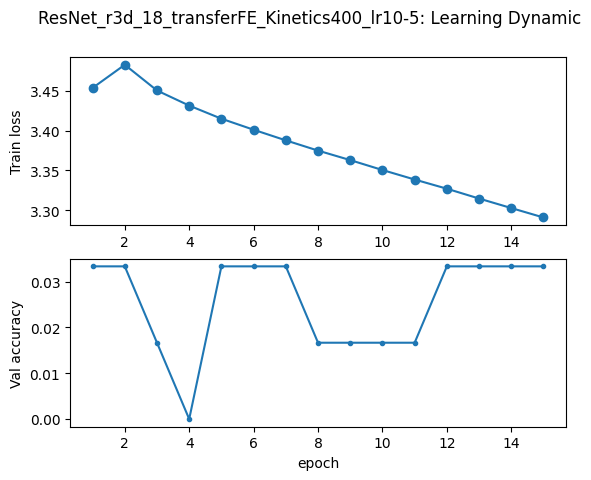

In [25]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)

In [26]:
#best_acc = 1/n_class

previous_epochs = 15
num_epoches = 15

# if use_cuda:
#   model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
#   cudnn.benchmark = True

# epochs = list()
# train_loss_dynamic = list()
# val_accuracy_dynamic = list()

for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 16/30: train_loss=3.2805; val acc=0.033
Train Epoch 17/30: train_loss=3.2678; val acc=0.033
Train Epoch 18/30: train_loss=3.2564; val acc=0.033
Train Epoch 19/30: train_loss=3.2444; val acc=0.033
Train Epoch 20/30: train_loss=3.2331; val acc=0.033
Train Epoch 21/30: train_loss=3.222; val acc=0.033
Train Epoch 22/30: train_loss=3.2105; val acc=0.033
Train Epoch 23/30: train_loss=3.1991; val acc=0.050
Train Epoch 24/30: train_loss=3.1877; val acc=0.050
Train Epoch 25/30: train_loss=3.176; val acc=0.050
Train Epoch 26/30: train_loss=3.1653; val acc=0.050
Train Epoch 27/30: train_loss=3.1541; val acc=0.067
Train Epoch 28/30: train_loss=3.143; val acc=0.083
Train Epoch 29/30: train_loss=3.132; val acc=0.083
Train Epoch 30/30: train_loss=3.1204; val acc=0.100


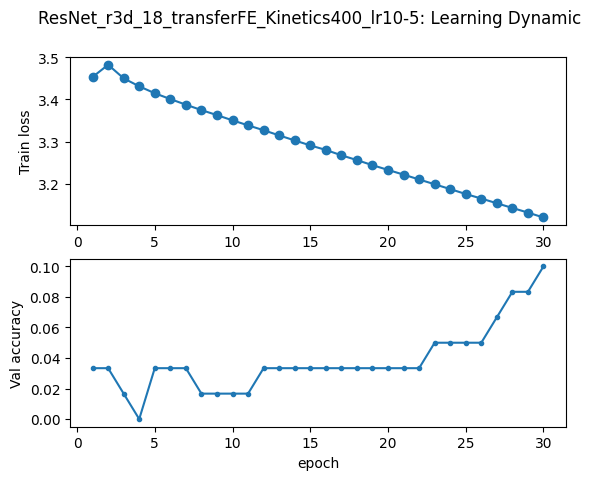

In [27]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)

In [28]:
#best_acc = 1/n_class

previous_epochs = 30
num_epoches = 15

# if use_cuda:
#   model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
#   cudnn.benchmark = True

# epochs = list()
# train_loss_dynamic = list()
# val_accuracy_dynamic = list()

for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 31/45: train_loss=3.1093; val acc=0.100
Train Epoch 32/45: train_loss=3.0985; val acc=0.100
Train Epoch 33/45: train_loss=3.088; val acc=0.100
Train Epoch 34/45: train_loss=3.0769; val acc=0.100
Train Epoch 35/45: train_loss=3.0659; val acc=0.117
Train Epoch 36/45: train_loss=3.0553; val acc=0.117
Train Epoch 37/45: train_loss=3.0446; val acc=0.150
Train Epoch 38/45: train_loss=3.0334; val acc=0.167
Train Epoch 39/45: train_loss=3.023; val acc=0.167
Train Epoch 40/45: train_loss=3.012; val acc=0.167
Train Epoch 41/45: train_loss=3.0016; val acc=0.167
Train Epoch 42/45: train_loss=2.9908; val acc=0.167
Train Epoch 43/45: train_loss=2.9805; val acc=0.167
Train Epoch 44/45: train_loss=2.9698; val acc=0.167
Train Epoch 45/45: train_loss=2.9595; val acc=0.167


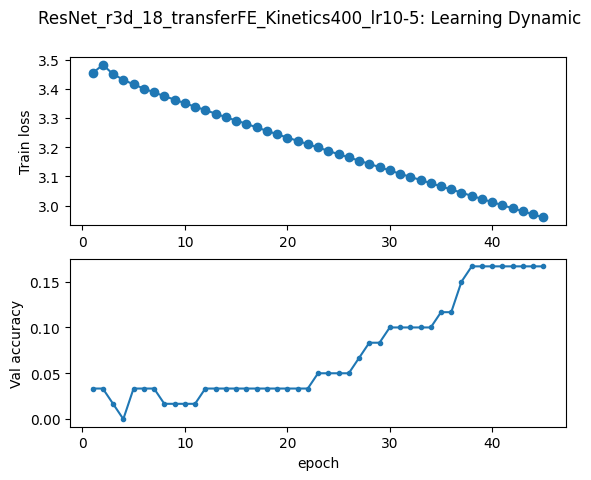

In [29]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)

In [30]:
#best_acc = 1/n_class

previous_epochs = 45
num_epoches = 15

# if use_cuda:
#   model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
#   cudnn.benchmark = True

# epochs = list()
# train_loss_dynamic = list()
# val_accuracy_dynamic = list()

for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 46/60: train_loss=2.9491; val acc=0.167
Train Epoch 47/60: train_loss=2.9394; val acc=0.167
Train Epoch 48/60: train_loss=2.929; val acc=0.167
Train Epoch 49/60: train_loss=2.9182; val acc=0.167
Train Epoch 50/60: train_loss=2.9076; val acc=0.167
Train Epoch 51/60: train_loss=2.8977; val acc=0.167
Train Epoch 52/60: train_loss=2.8875; val acc=0.167
Train Epoch 53/60: train_loss=2.8775; val acc=0.167
Train Epoch 54/60: train_loss=2.8674; val acc=0.167
Train Epoch 55/60: train_loss=2.8573; val acc=0.167
Train Epoch 56/60: train_loss=2.8474; val acc=0.167
Train Epoch 57/60: train_loss=2.8376; val acc=0.167
Train Epoch 58/60: train_loss=2.8275; val acc=0.167
Train Epoch 59/60: train_loss=2.8172; val acc=0.167
Train Epoch 60/60: train_loss=2.8084; val acc=0.167


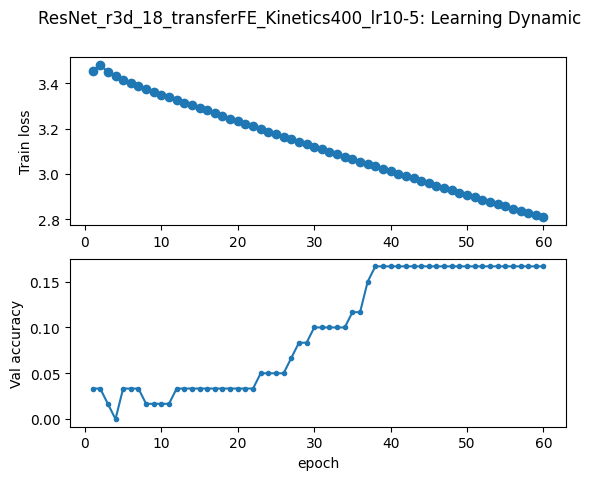

In [31]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)

In [32]:
#best_acc = 1/n_class

previous_epochs = 60
num_epoches = 15

# if use_cuda:
#   model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
#   cudnn.benchmark = True

# epochs = list()
# train_loss_dynamic = list()
# val_accuracy_dynamic = list()

for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 61/75: train_loss=2.7977; val acc=0.167
Train Epoch 62/75: train_loss=2.7883; val acc=0.167
Train Epoch 63/75: train_loss=2.7783; val acc=0.167
Train Epoch 64/75: train_loss=2.7691; val acc=0.167
Train Epoch 65/75: train_loss=2.7596; val acc=0.167
Train Epoch 66/75: train_loss=2.7499; val acc=0.167
Train Epoch 67/75: train_loss=2.7398; val acc=0.167
Train Epoch 68/75: train_loss=2.7312; val acc=0.167
Train Epoch 69/75: train_loss=2.7215; val acc=0.167
Train Epoch 70/75: train_loss=2.7116; val acc=0.167
Train Epoch 71/75: train_loss=2.7021; val acc=0.167
Train Epoch 72/75: train_loss=2.6927; val acc=0.167
Train Epoch 73/75: train_loss=2.6834; val acc=0.167
Train Epoch 74/75: train_loss=2.6743; val acc=0.183
Train Epoch 75/75: train_loss=2.6649; val acc=0.167


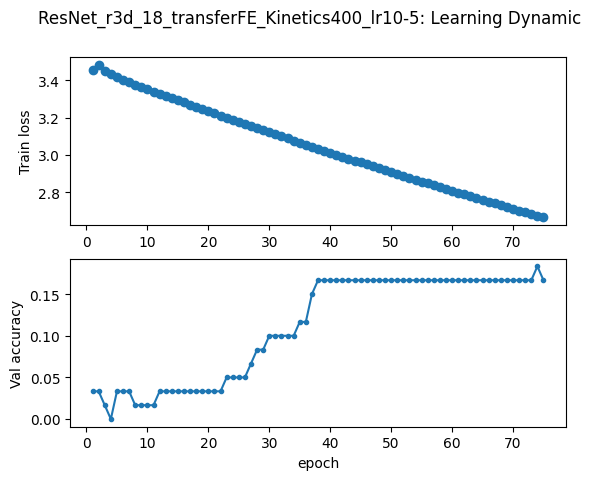

In [33]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)

In [34]:
#best_acc = 1/n_class

previous_epochs = 75
num_epoches = 15

# if use_cuda:
#   model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
#   cudnn.benchmark = True

# epochs = list()
# train_loss_dynamic = list()
# val_accuracy_dynamic = list()

for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 76/90: train_loss=2.6554; val acc=0.167
Train Epoch 77/90: train_loss=2.6463; val acc=0.167
Train Epoch 78/90: train_loss=2.637; val acc=0.150
Train Epoch 79/90: train_loss=2.6285; val acc=0.183
Train Epoch 80/90: train_loss=2.6192; val acc=0.183
Train Epoch 81/90: train_loss=2.6103; val acc=0.183
Train Epoch 82/90: train_loss=2.601; val acc=0.200
Train Epoch 83/90: train_loss=2.592; val acc=0.200
Train Epoch 84/90: train_loss=2.5829; val acc=0.200
Train Epoch 85/90: train_loss=2.574; val acc=0.183
Train Epoch 86/90: train_loss=2.5654; val acc=0.200
Train Epoch 87/90: train_loss=2.5563; val acc=0.200
Train Epoch 88/90: train_loss=2.5473; val acc=0.183
Train Epoch 89/90: train_loss=2.5393; val acc=0.183
Train Epoch 90/90: train_loss=2.5306; val acc=0.200


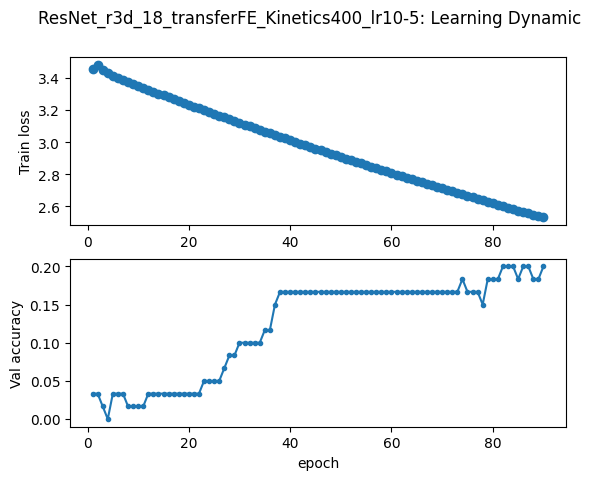

In [35]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)

In [36]:
#best_acc = 1/n_class

previous_epochs = 90
num_epoches = 15

# if use_cuda:
#   model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
#   cudnn.benchmark = True

# epochs = list()
# train_loss_dynamic = list()
# val_accuracy_dynamic = list()

for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 91/105: train_loss=2.5217; val acc=0.200
Train Epoch 92/105: train_loss=2.513; val acc=0.200
Train Epoch 93/105: train_loss=2.5041; val acc=0.200
Train Epoch 94/105: train_loss=2.4957; val acc=0.183
Train Epoch 95/105: train_loss=2.4876; val acc=0.183
Train Epoch 96/105: train_loss=2.4792; val acc=0.200
Train Epoch 97/105: train_loss=2.4701; val acc=0.200
Train Epoch 98/105: train_loss=2.4622; val acc=0.200
Train Epoch 99/105: train_loss=2.4533; val acc=0.200
Train Epoch 100/105: train_loss=2.4454; val acc=0.200
Train Epoch 101/105: train_loss=2.4369; val acc=0.200
Train Epoch 102/105: train_loss=2.4282; val acc=0.200
Train Epoch 103/105: train_loss=2.42; val acc=0.217
Train Epoch 104/105: train_loss=2.4124; val acc=0.217
Train Epoch 105/105: train_loss=2.4042; val acc=0.217


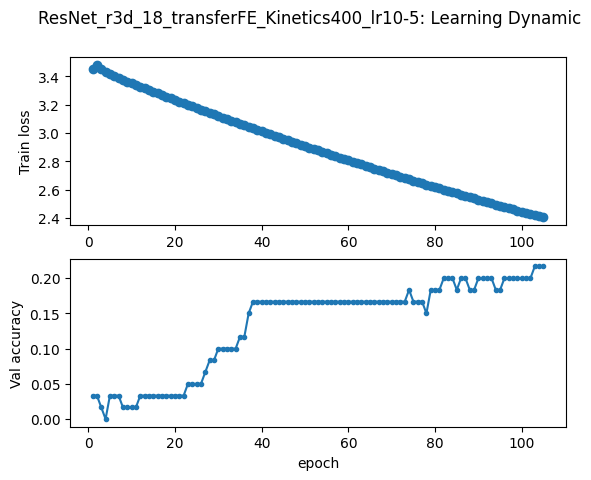

In [37]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)

In [38]:
#best_acc = 1/n_class

previous_epochs = 105
num_epoches = 15

# if use_cuda:
#   model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
#   cudnn.benchmark = True

# epochs = list()
# train_loss_dynamic = list()
# val_accuracy_dynamic = list()

for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 106/120: train_loss=2.3961; val acc=0.217
Train Epoch 107/120: train_loss=2.3873; val acc=0.217
Train Epoch 108/120: train_loss=2.3795; val acc=0.217
Train Epoch 109/120: train_loss=2.3711; val acc=0.217
Train Epoch 110/120: train_loss=2.3632; val acc=0.217
Train Epoch 111/120: train_loss=2.3555; val acc=0.217
Train Epoch 112/120: train_loss=2.3473; val acc=0.217
Train Epoch 113/120: train_loss=2.3397; val acc=0.217
Train Epoch 114/120: train_loss=2.3314; val acc=0.217
Train Epoch 115/120: train_loss=2.3241; val acc=0.217
Train Epoch 116/120: train_loss=2.3158; val acc=0.217
Train Epoch 117/120: train_loss=2.3081; val acc=0.217
Train Epoch 118/120: train_loss=2.3002; val acc=0.200
Train Epoch 119/120: train_loss=2.2926; val acc=0.200
Train Epoch 120/120: train_loss=2.2849; val acc=0.200


In [39]:
torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'classes': classes
                },
                    f'{save_path}/{model_name}-{epoch}-Val_acc-{predict_acc:.3f}.pth')

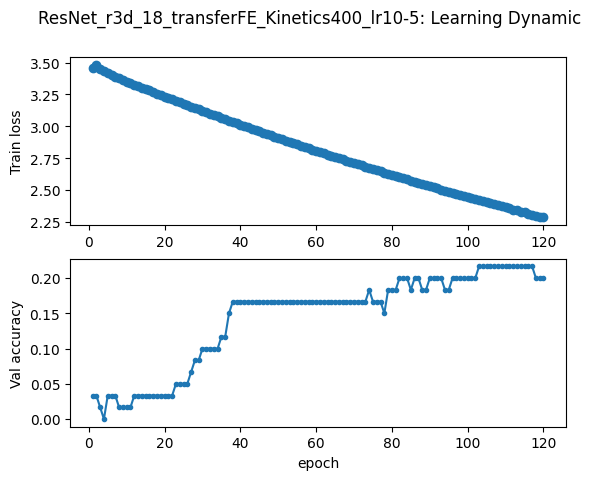

In [40]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)

In [44]:
previous_epochs = 120
num_epoches = 15

# if use_cuda:
#   model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
#   cudnn.benchmark = True

# epochs = list()
# train_loss_dynamic = list()
# val_accuracy_dynamic = list()

for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 121/135: train_loss=2.2769; val acc=0.217
Train Epoch 122/135: train_loss=2.2696; val acc=0.200
Train Epoch 123/135: train_loss=2.2618; val acc=0.217
Train Epoch 124/135: train_loss=2.2537; val acc=0.200
Train Epoch 125/135: train_loss=2.2464; val acc=0.200
Train Epoch 126/135: train_loss=2.2395; val acc=0.200
Train Epoch 127/135: train_loss=2.2315; val acc=0.200
Train Epoch 128/135: train_loss=2.2244; val acc=0.200
Train Epoch 129/135: train_loss=2.2171; val acc=0.200
Train Epoch 130/135: train_loss=2.2096; val acc=0.200
Train Epoch 131/135: train_loss=2.202; val acc=0.200
Train Epoch 132/135: train_loss=2.1945; val acc=0.200
Train Epoch 133/135: train_loss=2.1878; val acc=0.200
Train Epoch 134/135: train_loss=2.1796; val acc=0.200
Train Epoch 135/135: train_loss=2.1724; val acc=0.200


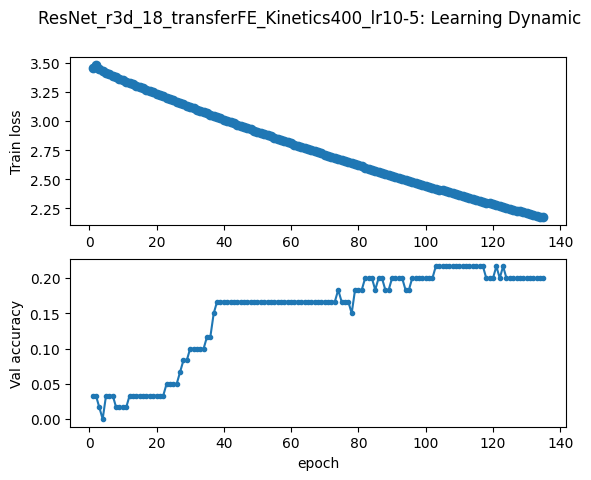

In [45]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)

In [46]:
previous_epochs = 135
num_epoches = 15

# if use_cuda:
#   model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
#   cudnn.benchmark = True

# epochs = list()
# train_loss_dynamic = list()
# val_accuracy_dynamic = list()

for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 136/150: train_loss=2.1657; val acc=0.200
Train Epoch 137/150: train_loss=2.1584; val acc=0.200
Train Epoch 138/150: train_loss=2.1511; val acc=0.200
Train Epoch 139/150: train_loss=2.1441; val acc=0.200
Train Epoch 140/150: train_loss=2.1369; val acc=0.200
Train Epoch 141/150: train_loss=2.1303; val acc=0.200
Train Epoch 142/150: train_loss=2.1228; val acc=0.200
Train Epoch 143/150: train_loss=2.1148; val acc=0.200
Train Epoch 144/150: train_loss=2.1093; val acc=0.217
Train Epoch 145/150: train_loss=2.1018; val acc=0.217
Train Epoch 146/150: train_loss=2.0949; val acc=0.217
Train Epoch 147/150: train_loss=2.0874; val acc=0.217
Train Epoch 148/150: train_loss=2.0811; val acc=0.217
Train Epoch 149/150: train_loss=2.0744; val acc=0.217
Train Epoch 150/150: train_loss=2.0684; val acc=0.217


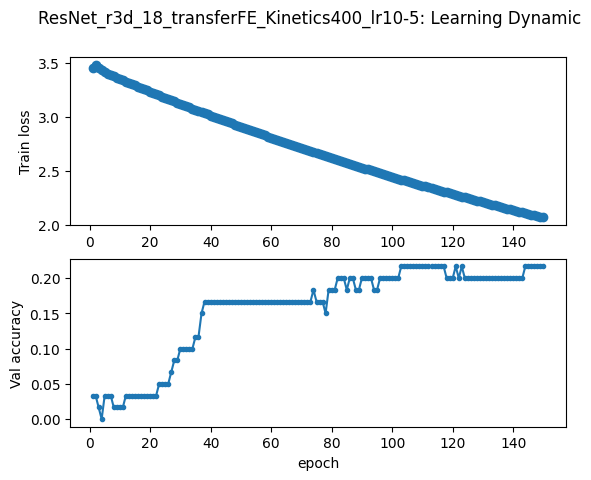

In [47]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)

In [48]:
previous_epochs = 150
num_epoches = 15

# if use_cuda:
#   model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
#   cudnn.benchmark = True

# epochs = list()
# train_loss_dynamic = list()
# val_accuracy_dynamic = list()

for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 151/165: train_loss=2.0606; val acc=0.217
Train Epoch 152/165: train_loss=2.0543; val acc=0.217
Train Epoch 153/165: train_loss=2.0471; val acc=0.217
Train Epoch 154/165: train_loss=2.0405; val acc=0.217
Train Epoch 155/165: train_loss=2.0336; val acc=0.217
Train Epoch 156/165: train_loss=2.0268; val acc=0.217
Train Epoch 157/165: train_loss=2.0199; val acc=0.217
Train Epoch 158/165: train_loss=2.0138; val acc=0.217
Train Epoch 159/165: train_loss=2.0072; val acc=0.217
Train Epoch 160/165: train_loss=2.0012; val acc=0.217
Train Epoch 161/165: train_loss=1.9939; val acc=0.217
Train Epoch 162/165: train_loss=1.9881; val acc=0.217
Train Epoch 163/165: train_loss=1.9814; val acc=0.217
Train Epoch 164/165: train_loss=1.9746; val acc=0.217
Train Epoch 165/165: train_loss=1.9689; val acc=0.217


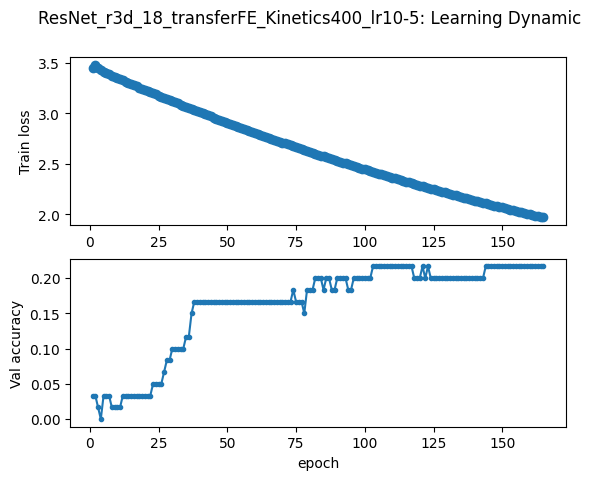

In [49]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)

In [50]:
previous_epochs = 165
num_epoches = 15

# if use_cuda:
#   model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
#   cudnn.benchmark = True

# epochs = list()
# train_loss_dynamic = list()
# val_accuracy_dynamic = list()

for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 166/180: train_loss=1.9617; val acc=0.217
Train Epoch 167/180: train_loss=1.9559; val acc=0.217
Train Epoch 168/180: train_loss=1.949; val acc=0.217
Train Epoch 169/180: train_loss=1.9425; val acc=0.217
Train Epoch 170/180: train_loss=1.9365; val acc=0.217
Train Epoch 171/180: train_loss=1.9306; val acc=0.217
Train Epoch 172/180: train_loss=1.9239; val acc=0.217
Train Epoch 173/180: train_loss=1.9181; val acc=0.217
Train Epoch 174/180: train_loss=1.9119; val acc=0.217
Train Epoch 175/180: train_loss=1.9056; val acc=0.217
Train Epoch 176/180: train_loss=1.9001; val acc=0.217
Train Epoch 177/180: train_loss=1.8935; val acc=0.217
Train Epoch 178/180: train_loss=1.8872; val acc=0.217
Train Epoch 179/180: train_loss=1.8811; val acc=0.217
Train Epoch 180/180: train_loss=1.8751; val acc=0.217


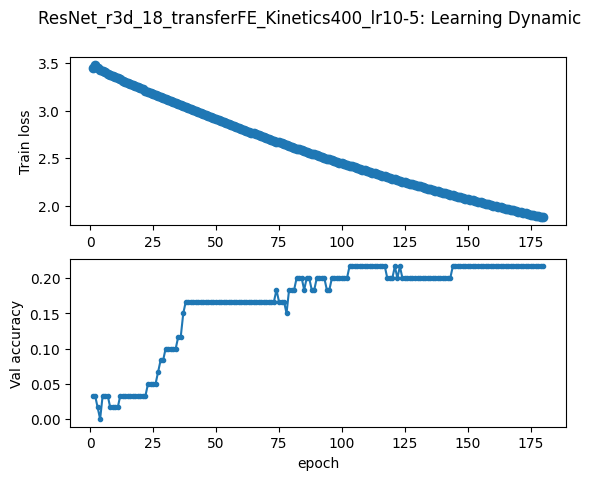

In [51]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)

In [52]:
previous_epochs = 180
num_epoches = 15

# if use_cuda:
#   model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
#   cudnn.benchmark = True

# epochs = list()
# train_loss_dynamic = list()
# val_accuracy_dynamic = list()

for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 181/195: train_loss=1.8692; val acc=0.217
Train Epoch 182/195: train_loss=1.8631; val acc=0.217
Train Epoch 183/195: train_loss=1.857; val acc=0.217
Train Epoch 184/195: train_loss=1.8509; val acc=0.217
Train Epoch 185/195: train_loss=1.8449; val acc=0.217
Train Epoch 186/195: train_loss=1.8388; val acc=0.217
Train Epoch 187/195: train_loss=1.8333; val acc=0.217
Train Epoch 188/195: train_loss=1.8273; val acc=0.217
Train Epoch 189/195: train_loss=1.8216; val acc=0.217
Train Epoch 190/195: train_loss=1.8157; val acc=0.217
Train Epoch 191/195: train_loss=1.8096; val acc=0.217
Train Epoch 192/195: train_loss=1.8041; val acc=0.217
Train Epoch 193/195: train_loss=1.7988; val acc=0.217
Train Epoch 194/195: train_loss=1.7928; val acc=0.217
Train Epoch 195/195: train_loss=1.7868; val acc=0.217


In [53]:
previous_epochs = 195
num_epoches = 15

# if use_cuda:
#   model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
#   cudnn.benchmark = True

# epochs = list()
# train_loss_dynamic = list()
# val_accuracy_dynamic = list()

for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 196/210: train_loss=1.7817; val acc=0.217
Train Epoch 197/210: train_loss=1.7753; val acc=0.217
Train Epoch 198/210: train_loss=1.7696; val acc=0.217
Train Epoch 199/210: train_loss=1.7644; val acc=0.217
Train Epoch 200/210: train_loss=1.7588; val acc=0.217
Train Epoch 201/210: train_loss=1.7536; val acc=0.217
Train Epoch 202/210: train_loss=1.7478; val acc=0.217
Train Epoch 203/210: train_loss=1.7421; val acc=0.217
Train Epoch 204/210: train_loss=1.7364; val acc=0.217
Train Epoch 205/210: train_loss=1.7316; val acc=0.217
Train Epoch 206/210: train_loss=1.7256; val acc=0.217
Train Epoch 207/210: train_loss=1.7203; val acc=0.217
Train Epoch 208/210: train_loss=1.7149; val acc=0.217
Train Epoch 209/210: train_loss=1.7091; val acc=0.217
Train Epoch 210/210: train_loss=1.704; val acc=0.217


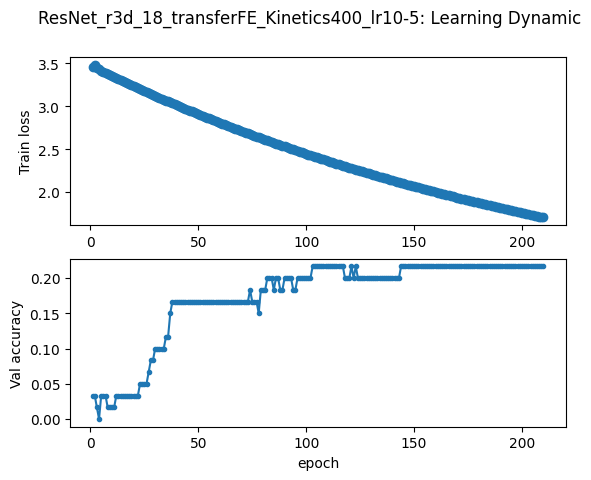

In [54]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)

In [55]:
previous_epochs = 210
num_epoches = 15

# if use_cuda:
#   model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
#   cudnn.benchmark = True

# epochs = list()
# train_loss_dynamic = list()
# val_accuracy_dynamic = list()

for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 211/225: train_loss=1.6986; val acc=0.200
Train Epoch 212/225: train_loss=1.6933; val acc=0.217
Train Epoch 213/225: train_loss=1.6878; val acc=0.217
Train Epoch 214/225: train_loss=1.6826; val acc=0.217
Train Epoch 215/225: train_loss=1.6771; val acc=0.200
Train Epoch 216/225: train_loss=1.6724; val acc=0.200
Train Epoch 217/225: train_loss=1.6668; val acc=0.200
Train Epoch 218/225: train_loss=1.662; val acc=0.200
Train Epoch 219/225: train_loss=1.6564; val acc=0.200
Train Epoch 220/225: train_loss=1.651; val acc=0.200
Train Epoch 221/225: train_loss=1.6457; val acc=0.200
Train Epoch 222/225: train_loss=1.6408; val acc=0.200
Train Epoch 223/225: train_loss=1.6357; val acc=0.200
Train Epoch 224/225: train_loss=1.6305; val acc=0.200
Train Epoch 225/225: train_loss=1.6253; val acc=0.200


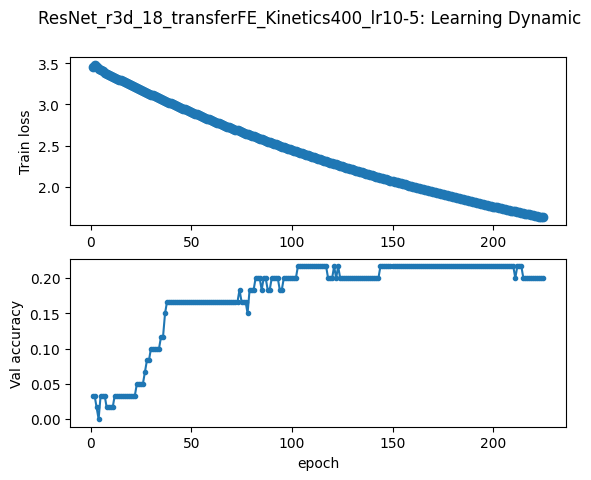

In [56]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)

In [57]:
previous_epochs = 225
num_epoches = 15

# if use_cuda:
#   model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
#   cudnn.benchmark = True

# epochs = list()
# train_loss_dynamic = list()
# val_accuracy_dynamic = list()

for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 226/240: train_loss=1.62; val acc=0.200
Train Epoch 227/240: train_loss=1.615; val acc=0.200
Train Epoch 228/240: train_loss=1.6104; val acc=0.183
Train Epoch 229/240: train_loss=1.6053; val acc=0.183
Train Epoch 230/240: train_loss=1.6003; val acc=0.183
Train Epoch 231/240: train_loss=1.5953; val acc=0.183
Train Epoch 232/240: train_loss=1.5903; val acc=0.183
Train Epoch 233/240: train_loss=1.585; val acc=0.200
Train Epoch 234/240: train_loss=1.5807; val acc=0.183
Train Epoch 235/240: train_loss=1.5757; val acc=0.183
Train Epoch 236/240: train_loss=1.5707; val acc=0.183
Train Epoch 237/240: train_loss=1.5658; val acc=0.200
Train Epoch 238/240: train_loss=1.5611; val acc=0.183
Train Epoch 239/240: train_loss=1.5561; val acc=0.183
Train Epoch 240/240: train_loss=1.5515; val acc=0.183


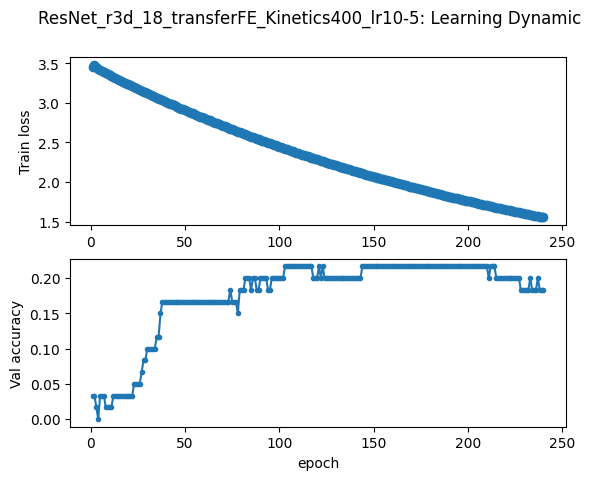

In [58]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)